### This is the same notebook as analyze_sql_data.ipynb but includes multiple years

In [16]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve, 
                            roc_auc_score, 
                            confusion_matrix
                            )
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [17]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

### Want something like:

    SELECT
        table4.countrycode as 'countrycode',
        b.table1 as 'table1',
        b.table2 as 'table2',
        b.table3 as 'table3',
        table4.year as 'table4'
        (SELECT
            table3.countrycode as 'countrycode',
            a.table1 as 'table1',
            a.table2 as 'table2',
            table3.year as 'table3'
         FROM
            (SELECT
                 table1.countrycode as 'countrycode',
                 table1.year as 'table1',
                 table2.year as 'table2'
             FROM
                 table1
             JOIN
                 table2
               ON 
                 table1.countrycode = table2.countrycode
             ) a
         JOIN
             table3
           ON
             a.countrycode = table3.countrycode  
        ) b    
    JOIN
        table4
      ON
        a.countrycode = table3.countrycode 
    
        
       


In [18]:
def makeSQLQuery(table_names, year):
    dotyyear = '.y' + str(year)
    current_unit = 'a'
    query = '(SELECT ' + table_names[0] + '.countrycode AS countrycode, ' + \
            table_names[0] + dotyyear + ' AS ' + table_names[0] + ', ' + \
            table_names[1] + dotyyear + ' AS ' + table_names[1] + \
            ' FROM ' + table_names[0] + \
            ' JOIN ' + table_names[1] + \
            ' ON ' + table_names[0] + '.countrycode=' + table_names[1] + '.countrycode) '
    query = query + current_unit
    
    for table in table_names[2:]:
        curr_index = table_names.index(table)
        temp_list = table_names[:curr_index+1]
        
        pre_string = '(SELECT ' + table + '.countrycode as countrycode'
        
        for temp_table in temp_list[:-1]:
            pre_string = pre_string + ', ' + current_unit + '.' + temp_table + ' AS ' + temp_table
        
        pre_string = pre_string + ', ' + table + dotyyear + ' AS ' + table
        
        query = pre_string + ' FROM ' + query + ' JOIN ' + table + \
                ' ON ' + current_unit + '.countrycode=' + table + '.countrycode) '
        
        current_unit = current_unit + 'a'
        query = query + current_unit
        
    query = query.rsplit(' ', 1)[0][1:-1]
    
    return query
    
    

In [19]:
table_names = ['civil_liberties', 'population_growth', 'political_rights', \
               'life_expectancy', 'terror', 'peace', \
               'population_15_64',  \
                'zscores']

In [20]:
x_cols = table_names[:-1]

In [21]:
years = [2008, 2009, 2010, 2011, 2012, 2013]

In [22]:
full_data = pd.DataFrame()

In [23]:
for year in years:
    query = makeSQLQuery(table_names, year)
    year_data = pd.read_sql_query(query, engine)
    year_data['year'] = year
    year_data = year_data.set_index(['countrycode', 'year'])
    full_data = pd.concat([full_data, year_data])
    


In [24]:
full_data

,,civil_liberties,population_growth,political_rights,life_expectancy,terror,peace,population_15_64,zscores
countrycode,year,,,,,,,,
AFG,2008,6,2.485315,5,58.225024,8.011,2.983,49.946087,6.546331355
AGO,2008,5,3.374180,6,49.847390,0.000,2.132,49.356104,0.281696206
ALB,2008,3,-0.767343,3,76.632317,0.000,1.911,66.816430,0.055357722
ARE,2008,5,13.810060,6,76.307756,0.000,1.584,84.600650,-0.267222176
ARG,2008,2,1.025393,2,75.166268,0.363,1.791,63.456290,-0.26793528
ARM,2008,4,-0.438964,6,73.945000,0.549,2.309,68.109386,0.080862762
AUS,2008,1,2.004022,1,81.395122,2.150,1.428,67.607537,-0.269460889
AUT,2008,1,0.313041,1,80.431707,3.017,1.278,67.666395,-0.269482667
AZE,2008,5,2.099854,6,70.062927,2.928,2.236,70.166088,-0.150740934


In [25]:
full_data['zscores'] = full_data['zscores'].astype(float)

full_data.loc[full_data['zscores'] > 0, 'zscores'] = 1
full_data.loc[full_data['zscores'] <= 0, 'zscores'] = 0

try:
    full_data.loc[full_data['freedom_status'] == 'F', 'freedom_status'] = -1
    full_data.loc[full_data['freedom_status'] == 'PF', 'freedom_status'] = 0
    full_data.loc[full_data['freedom_status'] == 'NF', 'freedom_status'] = 1
except:
    pass


In [26]:
#The rows to be dropped
full_data[full_data.isnull().any(axis=1)]

civil_liberties  population_growth  political_rights  \
countrycode year                                                         
SSD         2008              NaN           4.362664               NaN   
            2009              NaN           4.403674               NaN   
            2010              NaN           4.404235               NaN   
HRV         2011                2                NaN                 1   
LKA         2012                4                NaN                 5   

                  life_expectancy  terror  peace  population_15_64  zscores  
countrycode year                                                             
SSD         2008        52.593317   0.000  2.621         52.863172      NaN  
            2009        53.122659   0.000  2.621         53.048921      NaN  
            2010        53.664902   0.000  2.621         53.276511      NaN  
HRV         2011        76.775610   0.305  1.629         66.783153        1  
LKA         2012        74.068049   4.651  2.192         66.774724        1

In [27]:
full_data = full_data.dropna()

In [28]:
#Get Z scores of rows
for col in x_cols:
   full_data[col] = (full_data[col] - full_data[col].mean())/full_data[col].std(ddof=0)


/Users/kenn/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [29]:
def getScoreValues(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model=KNeighborsClassifier(n_neighbors=6), 
                   verbose=True, 
                   get_features=True
                  ):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)  
    
    feature_importances = None
    if get_features:
        try:
            feature_importances = model.feature_importances_
            #print(feature_importances)
        except AttributeError:
            pass
    
    if verbose:
        #print(pd.concat([y_test,pd.Series(y_pred, index=y_test.index)], axis = 1))
        print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(accuracy_score_value, \
                                                                       precision_score_value, \
                                                                       recall_score_value, \
                                                                       f1_score_value))
    
    return accuracy_score_value, precision_score_value, recall_score_value, f1_score_value, feature_importances

In [30]:
X = full_data[x_cols]
y = full_data['zscores']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [31]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Accuracy: 0.9184397163120568
Precision: 0.7209302325581395
Recall: 0.7380952380952381
f1: 0.7294117647058824


(0.91843971631205679,
 0.72093023255813948,
 0.73809523809523814,
 0.72941176470588243,
 array([ 0.10351041,  0.13926173,  0.09196117,  0.14330753,  0.02777738,
         0.25708929,  0.23709249]))

In [32]:
getScoreValues(X_train, X_test, y_train, y_test, BernoulliNB())

Accuracy: 0.8226950354609929
Precision: 0.42592592592592593
Recall: 0.5476190476190477
f1: 0.4791666666666667


(0.82269503546099287,
 0.42592592592592593,
 0.54761904761904767,
 0.47916666666666669,
 None)

In [33]:
getScoreValues(X_train, X_test, y_train, y_test, GaussianNB())

Accuracy: 0.8156028368794326
Precision: 0.4166666666666667
Recall: 0.5952380952380952
f1: 0.4901960784313726


(0.81560283687943258,
 0.41666666666666669,
 0.59523809523809523,
 0.49019607843137258,
 None)

In [34]:
getScoreValues(X_train, X_test, y_train, y_test, model=SVC())

Accuracy: 0.8900709219858156
Precision: 0.9230769230769231
Recall: 0.2857142857142857
f1: 0.43636363636363634


(0.89007092198581561,
 0.92307692307692313,
 0.2857142857142857,
 0.43636363636363634,
 None)

In [35]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.9361702127659575
Precision: 0.8529411764705882
Recall: 0.6904761904761905
f1: 0.7631578947368423


(0.93617021276595747,
 0.8529411764705882,
 0.69047619047619047,
 0.76315789473684226,
 array([ 0.09897246,  0.15304041,  0.07238716,  0.18402554,  0.12436145,
         0.19398971,  0.17322327]))

In [36]:
def getROCcurve(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6)):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
    print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='best')

AUC: 0.9637896825396826


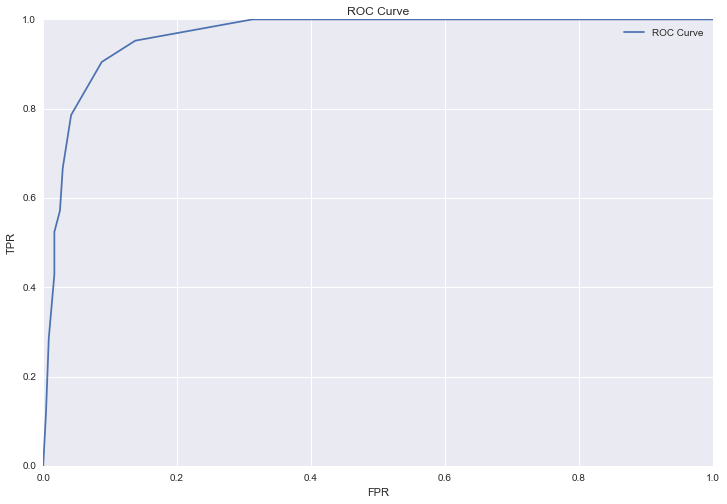

In [37]:
getROCcurve(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

In [38]:
def getScoreValuesByCV(X, y, model=KNeighborsClassifier(n_neighbors=5)):
    
    accuracy_score_value = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    precision_score_value = np.mean(cross_val_score(model, X, y, scoring='precision', cv=5))
    recall_score_value = np.mean(cross_val_score(model, X, y, scoring='recall', cv=5))
    f1_score_value = np.mean(cross_val_score(model, X, y, scoring='f1', cv=5))
    roc_auc_value = np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=5))
    #roc_auc_value = 0  
        
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(accuracy_score_value, \
                                                                   precision_score_value, \
                                                                   recall_score_value, \
                                                                   f1_score_value,
                                                                   roc_auc_value))

In [39]:
getScoreValuesByCV(X,y)

Accuracy: 0.9380816930253726
Precision: 0.8198473748473749
Recall: 0.7889655172413793
f1: 0.8029019269485188
ROC AUC: 0.9706947475629274


In [40]:
getScoreValuesByCV(X,y, model=RandomForestClassifier())

Accuracy: 0.9253043577198771
Precision: 0.9174906964380648
Recall: 0.6266666666666667
f1: 0.7273309323729491
ROC AUC: 0.9659093554488578


In [41]:
getScoreValuesByCV(X,y, model=GaussianNB())

Accuracy: 0.8046933667083854
Precision: 0.40848418185627483
Recall: 0.5443678160919541
f1: 0.4662008558893699
ROC AUC: 0.7485232067510548


In [42]:
getScoreValuesByCV(X,y, model=DecisionTreeClassifier())

Accuracy: 0.9274377062236887
Precision: 0.779621682665161
Recall: 0.7420689655172413
f1: 0.7685776874628184
ROC AUC: 0.8664120471409864


In [43]:
getScoreValuesByCV(X,y, model=LogisticRegression())

Accuracy: 0.8687336443281375
Precision: 0.8408730158730158
Recall: 0.20436781609195404
f1: 0.32715346925873245
ROC AUC: 0.7603302778990251


## Over sampling

In [44]:
X = full_data[x_cols]
y = full_data['zscores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [45]:
verbose = False
ratio = float(y.value_counts()[0]) / float(y.value_counts()[1])
X_train = X_train.reset_index(drop=True).as_matrix()
y_train = y_train.reset_index(drop=True).as_matrix()

smote = SMOTE(ratio=ratio, verbose=verbose)
smox, smoy = smote.fit_transform(X_train, y_train)

In [46]:
#smox

In [47]:
X_train = pd.DataFrame(smox, columns=x_cols)
y_train = pd.Series(smoy)

In [48]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.950354609929078
Precision: 0.8333333333333334
Recall: 0.8333333333333334
f1: 0.8333333333333334


(0.95035460992907805,
 0.83333333333333337,
 0.83333333333333337,
 0.83333333333333337,
 array([ 0.0826268 ,  0.16140413,  0.18566838,  0.17954128,  0.07708826,
         0.12647443,  0.18719672]))

In [49]:
getScoreValues(X_train, X_test, y_train, y_test, model=BernoulliNB())

Accuracy: 0.648936170212766
Precision: 0.2605042016806723
Recall: 0.7380952380952381
f1: 0.3850931677018634


(0.64893617021276595,
 0.26050420168067229,
 0.73809523809523814,
 0.38509316770186341,
 None)

In [50]:
getScoreValues(X_train, X_test, y_train, y_test, model=GaussianNB())

Accuracy: 0.6205673758865248
Precision: 0.24
Recall: 0.7142857142857143
f1: 0.3592814371257485


(0.62056737588652477,
 0.23999999999999999,
 0.7142857142857143,
 0.3592814371257485,
 None)

In [51]:
getScoreValues(X_train, X_test, y_train, y_test, model=DecisionTreeClassifier())

Accuracy: 0.9468085106382979
Precision: 0.8292682926829268
Recall: 0.8095238095238095
f1: 0.8192771084337348


(0.94680851063829785,
 0.82926829268292679,
 0.80952380952380953,
 0.8192771084337348,
 array([ 0.06788544,  0.13657638,  0.23430214,  0.25456189,  0.0843159 ,
         0.10417652,  0.11818172]))

In [52]:
getScoreValues(X_train, X_test, y_train, y_test)

Accuracy: 0.9219858156028369
Precision: 0.6851851851851852
Recall: 0.8809523809523809
f1: 0.7708333333333335


(0.92198581560283688,
 0.68518518518518523,
 0.88095238095238093,
 0.77083333333333348,
 None)

## Confusion Matrix

In [53]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not at Risk', 'At Risk'], rotation=45)
    plt.yticks(tick_marks, ['Not at Risk', 'At Risk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Cross validate with oversampling

In [54]:
def getCrossValScoresBySSS(local_X, 
                           local_y, 
                           n_iter=30, 
                           test_size=0.3, 
                           model=KNeighborsClassifier(n_neighbors=3),
                           get_multi_models=False,
                           get_models_avg=False,
                           get_cm=False,
                           verbose=True,
                           get_features=True
                          ):
    
    score_dict = {}
    acc_array = []
    prec_array = []
    recall_array = []
    f1_array = []
    feature_imp_array = []
    
    x_cols = list(local_X.columns)
    ratio = float(local_y.value_counts()[0]) / (.75*float(local_y.value_counts()[1]))
    sss = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size)
    
    model_list = [\
                  KNeighborsClassifier(n_neighbors=3), \
                  LogisticRegression(), \
                  BernoulliNB(), \
                  GaussianNB(), \
                  RandomForestClassifier(n_estimators=100), \
                  DecisionTreeClassifier() \
                  ]
    
    #Return table of scores for each model
    if get_multi_models:
        model_acc = []
        model_prec = []
        model_rec = []
        model_f1 = []
        for a_model in model_list:
            acc_array = []
            prec_array = []
            recall_array = []
            f1_array = []
            for train_index, test_index in sss:
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = X.ix[train_index], X.ix[test_index]
                y_train, y_test = y.ix[train_index], y.ix[test_index]

                X_train = X_train.reset_index(drop=True).as_matrix()
                y_train = y_train.reset_index(drop=True).as_matrix()

                smote = SMOTE(ratio=ratio, verbose=False)
                smox, smoy = smote.fit_transform(X_train, y_train)
                X_train = pd.DataFrame(smox, columns=x_cols)
                y_train = pd.Series(smoy)
            
                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value, _ = getScoreValues(X_train, 
                                                                   X_test, 
                                                                   y_train, 
                                                                   y_test, 
                                                                   model=a_model, 
                                                                   verbose=False,
                                                                   get_features=False)
                
                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)
                
            mean_acc = np.mean(acc_array)
            mean_prec = np.mean(prec_array)
            mean_recall = np.mean(recall_array)
            mean_f1 = np.mean(f1_array)
            
            model_acc.append(mean_acc)
            model_prec.append(mean_prec)
            model_rec.append(mean_recall)
            model_f1.append(mean_f1)
            
        score_dict['Accuracy'] = model_acc
        score_dict['Precision'] = model_prec
        score_dict['Recall'] = model_rec
        score_dict['F1'] = model_f1
        
        col_names = ['Accuracy', 'Precision', 'Recall', 'F1']
        index_func = [\
                  'KNeighborsClassifier(n_neighbors=3)', \
                  'LogisticRegression()', \
                  'BernoulliNB()', \
                  'GaussianNB()', \
                  'RandomForestClassifier(n_estimators=100)', \
                  'DecisionTreeClassifier()' \
                  ]
        df = pd.DataFrame(score_dict, columns=col_names, index=index_func)
        return df
    
    
    else:
        for train_index, test_index in sss:
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.ix[train_index], X.ix[test_index]
            y_train, y_test = y.ix[train_index], y.ix[test_index]

            X_train = X_train.reset_index(drop=True).as_matrix()
            y_train = y_train.reset_index(drop=True).as_matrix()

            smote = SMOTE(ratio=ratio, verbose=False)
            smox, smoy = smote.fit_transform(X_train, y_train)
            X_train = pd.DataFrame(smox, columns=x_cols)
            y_train = pd.Series(smoy)

            #Get scores of the average prediction of multiple models
            if get_models_avg:
                y_predictions = []

                for a_model in model_list:
                    temp_model = a_model
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    y_predictions.append(y_pred)

                average_prediction = np.mean(y_predictions, axis=0)
                average_prediction = [int(round(n, 0)) for n in average_prediction]

                accuracy_score_value = accuracy_score(y_test, y_pred)
                precision_score_value = precision_score(y_test, y_pred)
                recall_score_value = recall_score(y_test, y_pred)
                f1_score_value = f1_score(y_test, y_pred)

                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)

            #Get score values for each fold
            else:
                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value, \
                feature_importances = getScoreValues(X_train, 
                                                     X_test, 
                                                     y_train,
                                                     y_test, 
                                                     model=model, 
                                                     verbose=False,
                                                     get_features=get_features)

                if get_cm:
                    # For getting a confusion matrix of the last model in the cross validated set
                    temp_model = model
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)

                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)
                feature_imp_array.append(feature_importances)

        if get_cm:
            try:
                cm = confusion_matrix(y_test, average_prediction)
            except:
                cm = confusion_matrix(y_test, y_pred)
            plt.figure()
            plot_confusion_matrix(cm)

        mean_acc = np.mean(acc_array)
        mean_prec = np.mean(prec_array)
        mean_recall = np.mean(recall_array)
        mean_f1 = np.mean(f1_array)
        try:
            mean_feature_imp = np.mean(feature_imp_array, axis=0)
        except TypeError:
            mean_feature_imp = None
            
            
        if verbose:
            print('Avg Feature Importance: {}'.format(mean_feature_imp))
            print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(mean_acc, \
                                                                           mean_prec, \
                                                                           mean_recall,\
                                                                           mean_f1))

In [55]:
X = full_data[x_cols]
y = full_data['zscores']

## Scores for various models

In [56]:
getCrossValScoresBySSS(X, y, get_multi_models=True)

,Accuracy,Precision,Recall,F1
KNeighborsClassifier(n_neighbors=3),0.935461,0.729813,0.937121,0.819452
LogisticRegression(),0.584634,0.242657,0.780303,0.369712
BernoulliNB(),0.601418,0.237891,0.706818,0.355562
GaussianNB(),0.601300,0.235206,0.688636,0.350308
RandomForestClassifier(n_estimators=100),0.938298,0.788547,0.834848,0.808657
DecisionTreeClassifier(),0.908865,0.686477,0.775000,0.726182


#### KNN various n


n =  1
Avg Feature Importance: None
Accuracy: 0.9553191489361704
Precision: 0.8313007037641172
Recall: 0.9007575757575758
f1: 0.8631417245179775


n =  2
Avg Feature Importance: None
Accuracy: 0.9556737588652484
Precision: 0.853985177677401
Recall: 0.8712121212121213
f1: 0.8601813160262057


n =  3
Avg Feature Importance: None
Accuracy: 0.9346335697399529
Precision: 0.7279198911721472
Recall: 0.9393939393939394
f1: 0.8187484213057529


n =  4
Avg Feature Importance: None
Accuracy: 0.937115839243499
Precision: 0.744955062537478
Recall: 0.9166666666666666
f1: 0.8205633868381


n =  5
Avg Feature Importance: None
Accuracy: 0.9099290780141847
Precision: 0.644034585112117
Recall: 0.9590909090909092
f1: 0.7696205488161988


n =  6
Avg Feature Importance: None
Accuracy: 0.9114657210401894
Precision: 0.6526713642764564
Recall: 0.9409090909090908
f1: 0.7694686668597351


n =  7
Avg Feature Importance: None
Accuracy: 0.8762411347517731
Precision: 0.5625703873401309
Recall: 0.9749999999999999
f1:

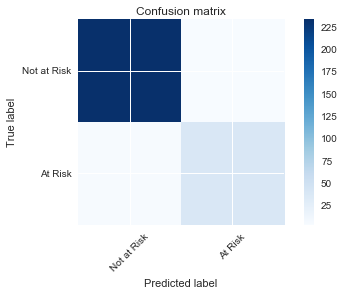

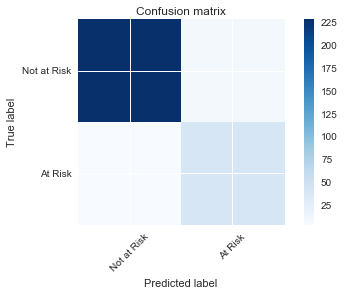

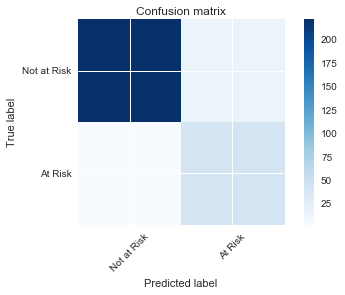

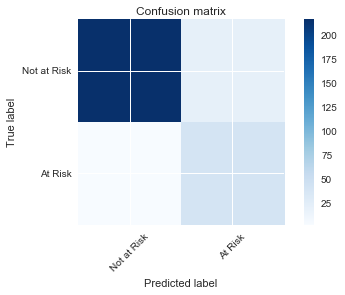

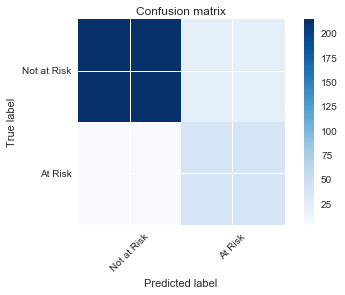

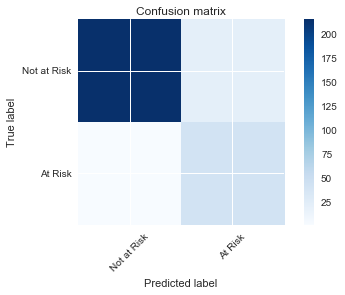

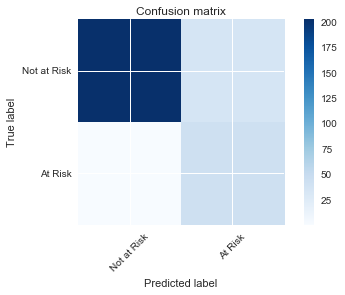

In [57]:
for n in range(1,8):
    print('n = ', n)
    getCrossValScoresBySSS(X, y, model=KNeighborsClassifier(n_neighbors=n), get_cm=True)
    print('\n')

#### Random Forest for important features

Avg Feature Importance: [ 0.14513742  0.1337308   0.14654294  0.15493124  0.10378791  0.14057893
  0.17529077]
Accuracy: 0.938888888888889
Precision: 0.7937530778595068
Recall: 0.8310606060606062
f1: 0.8091383333081745


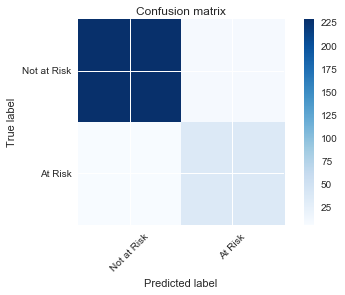

In [58]:
getCrossValScoresBySSS(X, y, model=RandomForestClassifier(n_estimators=30), get_cm = True)

#### DecisionTreeClassifier for important features

Avg Feature Importance: [ 0.1041167   0.20316633  0.21823316  0.12021166  0.08010927  0.12968893
  0.14447395]
Accuracy: 0.9091016548463361
Precision: 0.6882743049822512
Recall: 0.7712121212121211
f1: 0.7257758476218772


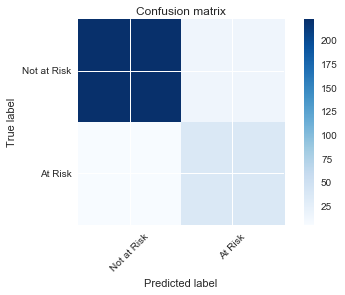

In [59]:
getCrossValScoresBySSS(X, y, model=DecisionTreeClassifier(), get_cm = True)

### Model averages:

In [60]:
getCrossValScoresBySSS(X, y, get_models_avg=True)

Avg Feature Importance: nan
Accuracy: 0.9301418439716315
Precision: 0.7167870231875153
Recall: 0.9242424242424243
f1: 0.8060882256772236


/Users/kenn/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
